# Art Generation with Neural Style Transfer

Using Neural Style Transfer (NST) this notebook merges two images, namely: a **"content" image (C) and a "style" image (S), to create a "generated" image (G**). 

The generated image G combines the "content" of the image C with the "style" of image S. 

In this example, we will generate an image of the Louvre museum in Paris (content image C), mixed with a painting by Claude Monet, a leader of the impressionist movement (style image S).
<img src="images/louvre_generated.png" style="width:750px;height:200px;">

<u>Content C</u><br>
Usually the middle layer's activations are chosen as G's content needs to be similar to that of C.
The content cost function is defined as:
$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$
where $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer and $a^{(C)}$ and $a^{(G)}$ are the 3D volumes corresponding to a hidden layer's activations. The 3D volume is rolled into a 2D matrix, i.e. shape would be changed from $(m,n_H,n_W,n_C)$ to $(m, n_H \times n_W, n_C)$

<u>Style S</u><br>
The style matrix is also called a "Gram matrix". $G_{gram}$ is of dimension $(n_C,n_C)$ where $n_C$ is the number of filters (channels). $G_{gram}$ of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{(gram)i,j} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. The value $G_{(gram)i,j}$ measures how similar the activations of filter $i$ are to the activations of filter $j$. The diagonal elements $G_{(gram)ii}$ measure how "active" a filter $i$ is. Suppose filter $i$ is detecting vertical textures in the image. Then $G_{(gram)ii}$ measures how common  vertical textures are in the image as a whole. If $G_{(gram)ii}$ is large, this means that the image has a lot of vertical texture. 
$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$
With only a single hidden layer $a^{[l]}$, the corresponding style cost for this layer is defined as: 
$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$ where  $G_{gram}^{(S)}$ and $G_{gram}^{(G)}$ are the Gram matrices of the "style" image and the "generated" image respectively. 
We can combine the style costs for different layers as follows: $$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$ where the values for $\lambda^{[l]}$ reflect how much each layer will contribute to the style such that $\sum_{l}^L\lambda^{[l]} = 1$.
<br>
<br>
Finally, both style and content costs are added.
$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

<u>Optimization Problem</u>
1. Create an Interactive Session
2. Load the content image 
3. Load the style image
4. Randomly initialize the image to be generated 
5. Load the VGG19 model
7. Build the TensorFlow graph:
    - Run the content image through the VGG19 model and compute the content cost
    - Run the style image through the VGG19 model and compute the style cost
    - Compute the total cost
    - Define the optimizer and the learning rate
8. Initialize the TensorFlow graph and run it for a large number of iterations, updating the generated image at every step.

<br>
<u>Model</u><br>
A pre-trained network from the original NST paper, VGG-19 trained on the ImageNet database is used here. The model was taken from [here](https://www.kaggle.com/teksab/imagenetvggverydeep19mat/data). The model is stored in a python dictionary with key as the variable name and value as the tensor for that layer.

Version notes: tensorflow v1.4.0, Keras v2.1.4, scipy v1.1.0, numpy v1.16.4 (downgraded for incompatibility with tf)

In [21]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline

from nstutils import *

import warnings
warnings.filterwarnings(action="ignore", category=FutureWarning)

c:\users\srotaswati panda\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


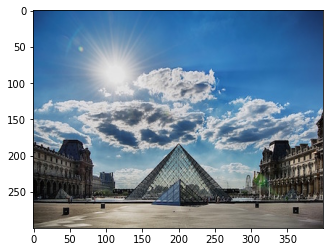

In [2]:
content_image = scipy.misc.imread("data/nstimages/louvre_small.jpg")
imshow(content_image)
content_image = reshape_and_normalize_image(content_image)

c:\users\srotaswati panda\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


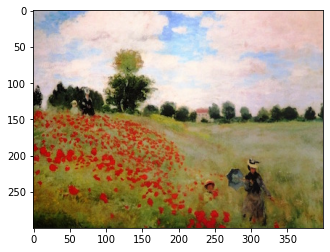

In [3]:
style_image = scipy.misc.imread("data/nstimages/monet.jpg")
imshow(style_image)
style_image = reshape_and_normalize_image(style_image)

In [4]:
pp = pprint.PrettyPrinter(indent=4)
model = load_vgg_model("models/imagenet-vgg-verydeep-19.mat")
pp.pprint(model)

{   'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>,
    'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>,
    'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>,
    'avgpool4': <tf.Tensor 'AvgPool_3:0' shape=(1, 19, 25, 512) dtype=float32>,
    'avgpool5': <tf.Tensor 'AvgPool_4:0' shape=(1, 10, 13, 512) dtype=float32>,
    'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) 

In [5]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
  
    a_C_unrolled = tf.reshape(a_C, [-1])
    a_G_unrolled = tf.reshape(a_G, [-1])
    
    J_content = tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))/(4 * n_H * n_W * n_C)
    
    return J_content

In [6]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    GA = tf.matmul(A, tf.transpose(A))
    
    return GA

In [7]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S, [n_H * n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H * n_W, n_C]))

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = tf.reduce_sum(tf.square(GS - GG))/(2 * n_C * n_H * n_W)**2
    
    return J_style_layer

In [8]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [9]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        out = model[layer_name]  # Select the output tensor of the currently selected layer
        a_S = sess.run(out)
        a_G = out                # a_G is not evaluated yet# GRADED FUNCTION: total_cost
        
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        J_style += coeff * J_style_layer

    return J_style

In [10]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J = alpha * J_content + beta * J_style
    
    return J  

In [11]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


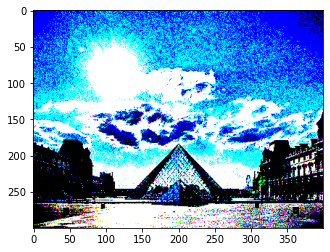

In [12]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0]);

In [13]:
model = load_vgg_model("models/imagenet-vgg-verydeep-19.mat")

In [14]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [15]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [16]:
J = total_cost(J_content, J_style)

In [17]:
optimizer = tf.train.AdamOptimizer(2.0) # learning rate of 2.0
train_step = optimizer.minimize(J)

In [18]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    sess.run(tf.global_variables_initializer())
 
    # Run the noisy input image (initial generated image) through the model. Use assign().
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])

        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + ":" + " Costs: total = " + str(Jt) + ", content = " + str(Jc) + ", style = " + str(Js))
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [19]:
img = model_nn(sess, generated_image)

Iteration 0: Costs: total = 4947489300.0, content = 7821.371, style = 123685270.0
Iteration 20: Costs: total = 937466400.0, content = 15109.401, style = 23432882.0
Iteration 40: Costs: total = 476756600.0, content = 16583.486, style = 11914770.0
Iteration 60: Costs: total = 304587300.0, content = 17287.54, style = 7610360.5
Iteration 80: Costs: total = 223365620.0, content = 17689.799, style = 5579718.0
Iteration 100: Costs: total = 177760240.0, content = 17951.54, style = 4439518.0
Iteration 120: Costs: total = 148047140.0, content = 18166.045, style = 3696637.0
Iteration 140: Costs: total = 126824360.0, content = 18333.28, style = 3166025.5
Iteration 160: Costs: total = 110451250.0, content = 18479.945, style = 2756661.2
Iteration 180: Costs: total = 97437630.0, content = 18590.105, style = 2431293.2


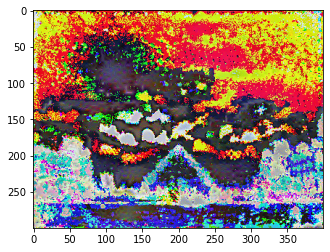

In [20]:
plt.imshow(img[-1].astype(np.uint8))